In [377]:
import torch
from pykan.kan.spline import curve2coef, coef2curve, B_batch
from pykan.kan.KAN import KAN
from torch import nn

import numpy as np
from tqdm import tqdm

In [378]:
class LAN_layer(nn.Module):
    def __init__(
        self,
        dim=2,
        num=5,
        k=3,
        noise_scale=0.1,
        scale_base=1.0,
        scale_sp=1.0,
        base_fun=torch.nn.SiLU(),
        grid_eps=0.02,
        grid_range=[-1,1],
        sp_trainable=True,
        sb_trainable=True,
        device='cpu'
    ):
        super().__init__()

        self.dim = dim
        self.num = num
        self.k = k 
        self.base_fun = base_fun
        self.device = device

        self.scale_base = scale_base
        self.scale_sp = scale_sp

        # определить grid
        self.grid = torch.einsum('i,j->ij', torch.ones(self.dim, device=device), torch.linspace(grid_range[0], grid_range[1], steps=num + 1, device=device))
        self.grid = torch.nn.Parameter(self.grid).requires_grad_(False)

        noises = (torch.rand(self.dim, self.grid.shape[1]) - 1 / 2) * noise_scale / num
        noises = noises.to(device)
        # shape: (size, coef)
        self.coef = torch.nn.Parameter(curve2coef(self.grid, noises, self.grid, k, device))

        self.bias = nn.Linear(dim, 1, bias=False, device=device)
        self.bias.weight.data *= 0.

        self.acts_scale = 

    def forward(self, x):
        # (batch, dim) -> (dim, batch)
        x = x.permute(1, 0)
        y = coef2curve(x_eval=x, grid=self.grid, coef=self.coef, k=self.k, device=self.device).permute(1, 0)  # shape (batch, dim)

        base = self.base_fun(x).permute(1, 0)  # shape (batch, size)
        y = self.scale_base * base + self.scale_sp * y

        input_range = grid_reshape[:, :, -1] - grid_reshape[:, :, 0] + 1e-4
        output_range = torch.mean(torch.abs(postacts), dim=0)
        self.acts_scale.append(output_range / input_range)

        return y + self.bias.weight
    
    # def update_grid_from_samples(self, x):
    #     batch = x.shape[0]
    #     x = torch.einsum('ij,k->ikj', x, torch.ones(self.dim, ).to(self.device)).reshape(batch, self.size).permute(1, 0)
    #     x_pos = torch.sort(x, dim=1)[0]
    #     y_eval = coef2curve(x_pos, self.grid, self.coef, self.k, device=self.device)
    #     num_interval = self.grid.shape[1] - 1
    #     ids = [int(batch / num_interval * i) for i in range(num_interval)] + [-1]
    #     grid_adaptive = x_pos[:, ids]
    #     margin = 0.01
    #     grid_uniform = torch.cat([grid_adaptive[:, [0]] - margin + (grid_adaptive[:, [-1]] - grid_adaptive[:, [0]] + 2 * margin) * a for a in np.linspace(0, 1, num=self.grid.shape[1])], dim=1)
    #     self.grid.data = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
    #     self.coef.data = curve2coef(x_pos, y_eval, self.grid, self.k, device=self.device)

In [379]:
device = 'cuda'

In [380]:
# from datasets import load_dataset

# dataset = load_dataset("mnist")

In [381]:
from pykan.kan.utils import create_dataset

f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2) + torch.sin(x[:,[0]] * x[:,[1]])
dataset = create_dataset(f, n_var=2, train_num=10000, test_num=10000)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([10000, 2]), torch.Size([10000, 1]))

In [382]:
SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)

In [383]:
num = 17

model_lan = nn.Sequential(
    nn.Linear(2, 5),
    nn.BatchNorm1d(5),

    LAN_layer(5, num=num, grid_range=[-1, 1], device=device),

    nn.Linear(5, 1),
).to(device)

model_mlp = nn.Sequential(
    nn.Linear(2, 5),
    nn.BatchNorm1d(5),

    nn.Linear(5, 9),
    nn.ReLU(True),
    nn.Linear(9, 5),
    nn.ReLU(True),

    nn.Linear(5, 1),
).to(device)

model_kan = KAN(width=[2,3,1], grid=5, k=3, seed=SEED, device=device).to(device)

In [384]:
def get_n_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

In [385]:
get_n_params(model_lan), get_n_params(model_mlp), get_n_params(model_kan)

(136, 135, 130)

In [386]:
batch_size = 128
batch_size_test = 128
steps = 2000

optimizer_lan = torch.optim.AdamW(model_lan.parameters(), lr=1e-3)
optimizer_mlp = torch.optim.AdamW(model_mlp.parameters(), lr=1e-3)
optimizer_kan = torch.optim.AdamW(model_kan.parameters(), lr=1e-3)

loss_fn = loss_fn_eval = lambda x, y: torch.mean((x - y) ** 2)

In [387]:
list(filter(lambda x: x.__class__.__name__ == 'LAN_layer', model_lan))[0].coef

Parameter containing:
tensor([[-6.0301e-04, -1.3808e-03,  3.6346e-03,  4.4623e-04, -2.8111e-03,
          2.5600e-03, -2.9306e-03,  1.0317e-03, -3.2657e-03,  4.8636e-03,
         -4.4820e-03, -8.6563e-04, -1.9097e-04, -3.3536e-03,  2.9946e-03,
         -6.9593e-03,  7.4130e-03, -6.7555e-03,  4.6183e-03,  1.9063e-03],
        [ 6.0860e-04,  1.2491e-03, -2.6683e-03,  3.6938e-03, -1.2020e-03,
          3.8644e-03,  2.6419e-06, -1.9458e-03,  2.2150e-03, -2.1729e-03,
          1.6910e-03,  2.8357e-03,  2.7219e-03, -3.5224e-03,  3.6527e-03,
         -9.0147e-04,  3.1107e-03, -2.5795e-03, -3.5487e-03, -6.9463e-04],
        [ 2.3624e-04, -6.5849e-04, -4.4204e-03,  4.8044e-03, -3.1703e-04,
          1.5466e-03,  1.4401e-03, -1.7261e-03,  5.1573e-03, -5.0923e-03,
          2.6735e-03, -4.4905e-03,  3.2437e-03, -3.0427e-03,  2.8499e-03,
         -2.9494e-03,  5.2713e-03, -3.4993e-03, -1.7336e-03, -9.1123e-05],
        [-1.3876e-03, -3.5771e-03,  5.1706e-03, -1.2328e-03,  5.6416e-03,
         -4.3

In [388]:

from collections import defaultdict

pbar = tqdm(range(steps), desc='description', ncols=100)

test_losses = defaultdict(list)
train_losses = defaultdict(list)

def reg(model):
    lamb_l1 = 1.
    lamb_entropy=2.
    small_mag_threshold=1e-16
    small_reg_factor=1.
    lamb_coef=1.
    lamb_coefdiff=1.

    def nonlinear(x, th=small_mag_threshold, factor=small_reg_factor):
        return (x < th) * x * factor + (x > th) * (x + (factor - 1) * th)

    reg_ = 0.
    # for i in range(len(acts_scale)):
    #     vec = acts_scale[i].reshape(-1, )

    #     p = vec / torch.sum(vec)
    #     l1 = torch.sum(nonlinear(vec))
    #     entropy = - torch.sum(p * torch.log2(p + 1e-4))
    #     reg_ += lamb_l1 * l1 + lamb_entropy * entropy  # both l1 and entropy

    # regularize coefficient to encourage spline to be zero
    for layer in list(filter(lambda x: x.__class__.__name__ == 'LAN_layer', model_lan)):
        coeff_l1 = torch.sum(torch.mean(torch.abs(layer.coef), dim=1))
        coeff_diff_l1 = torch.sum(torch.mean(torch.abs(torch.diff(layer.coef)), dim=1))
        reg_ += lamb_coef * coeff_l1 + lamb_coefdiff * coeff_diff_l1

    return reg_

def update(model, optimizer, dataset, train_id, test_id, loss_fn, loss_fn_eval, device):

    reguralize = reg(model)
    
    pred = model(dataset['train_input'][train_id].to(device)) 
    train_loss = loss_fn(pred, dataset['train_label'][train_id].to(device)) + reguralize
    loss = train_loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    test_loss = loss_fn_eval(model(dataset['test_input'][test_id].to(device)), dataset['test_label'][test_id].to(device))

    return train_loss, test_loss
        

for _ in pbar:
    train_id = np.random.choice(dataset['train_input'].shape[0], batch_size, replace=False)
    test_id = np.random.choice(dataset['test_input'].shape[0], batch_size_test, replace=False)

    # lan
    train_loss, test_loss = update(model_lan, optimizer_lan, dataset, train_id, test_id, loss_fn, loss_fn_eval, device)
    test_losses['lan'].append(test_loss.item())
    train_losses['lan'].append(train_loss.item())

    #mlp
    train_loss, test_loss = update(model_mlp, optimizer_mlp, dataset, train_id, test_id, loss_fn, loss_fn_eval, device)
    test_losses['mlp'].append(test_loss.item())
    train_losses['mlp'].append(train_loss.item())

    #kan
    train_loss, test_loss = update(model_kan, optimizer_kan, dataset, train_id, test_id, loss_fn, loss_fn_eval, device)
    test_losses['kan'].append(test_loss.item())
    train_losses['kan'].append(train_loss.item())

    # reg_ = reg(self.acts_scale)

description: 100%|██████████████████████████████████████████████| 2000/2000 [00:44<00:00, 45.43it/s]


In [389]:
import matplotlib.pyplot as plt

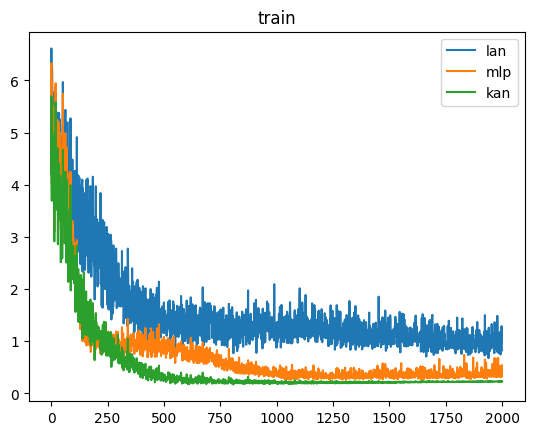

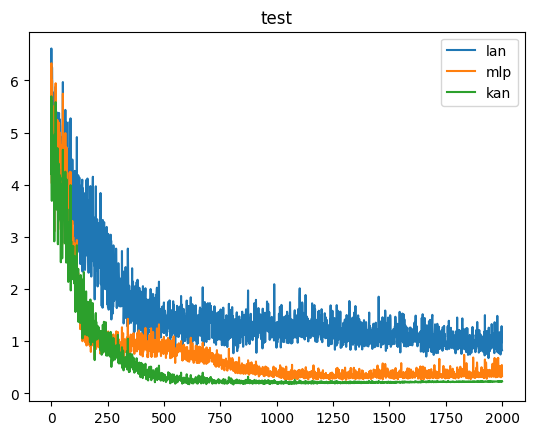

In [390]:
for x in train_losses:
    plt.plot(train_losses[x], label=x)
plt.title('train')
plt.legend()
plt.show()


for x in test_losses:
    plt.plot(train_losses[x], label=x)
plt.title('test')
plt.legend()
plt.show()